# Language Models

Language models (LMs) estimate the probability of different linguistic units: words, symbols, tokens, token sequences.\
A good Language Model assigns higher probability to textual fragments that are "more likely" to appear in a language.


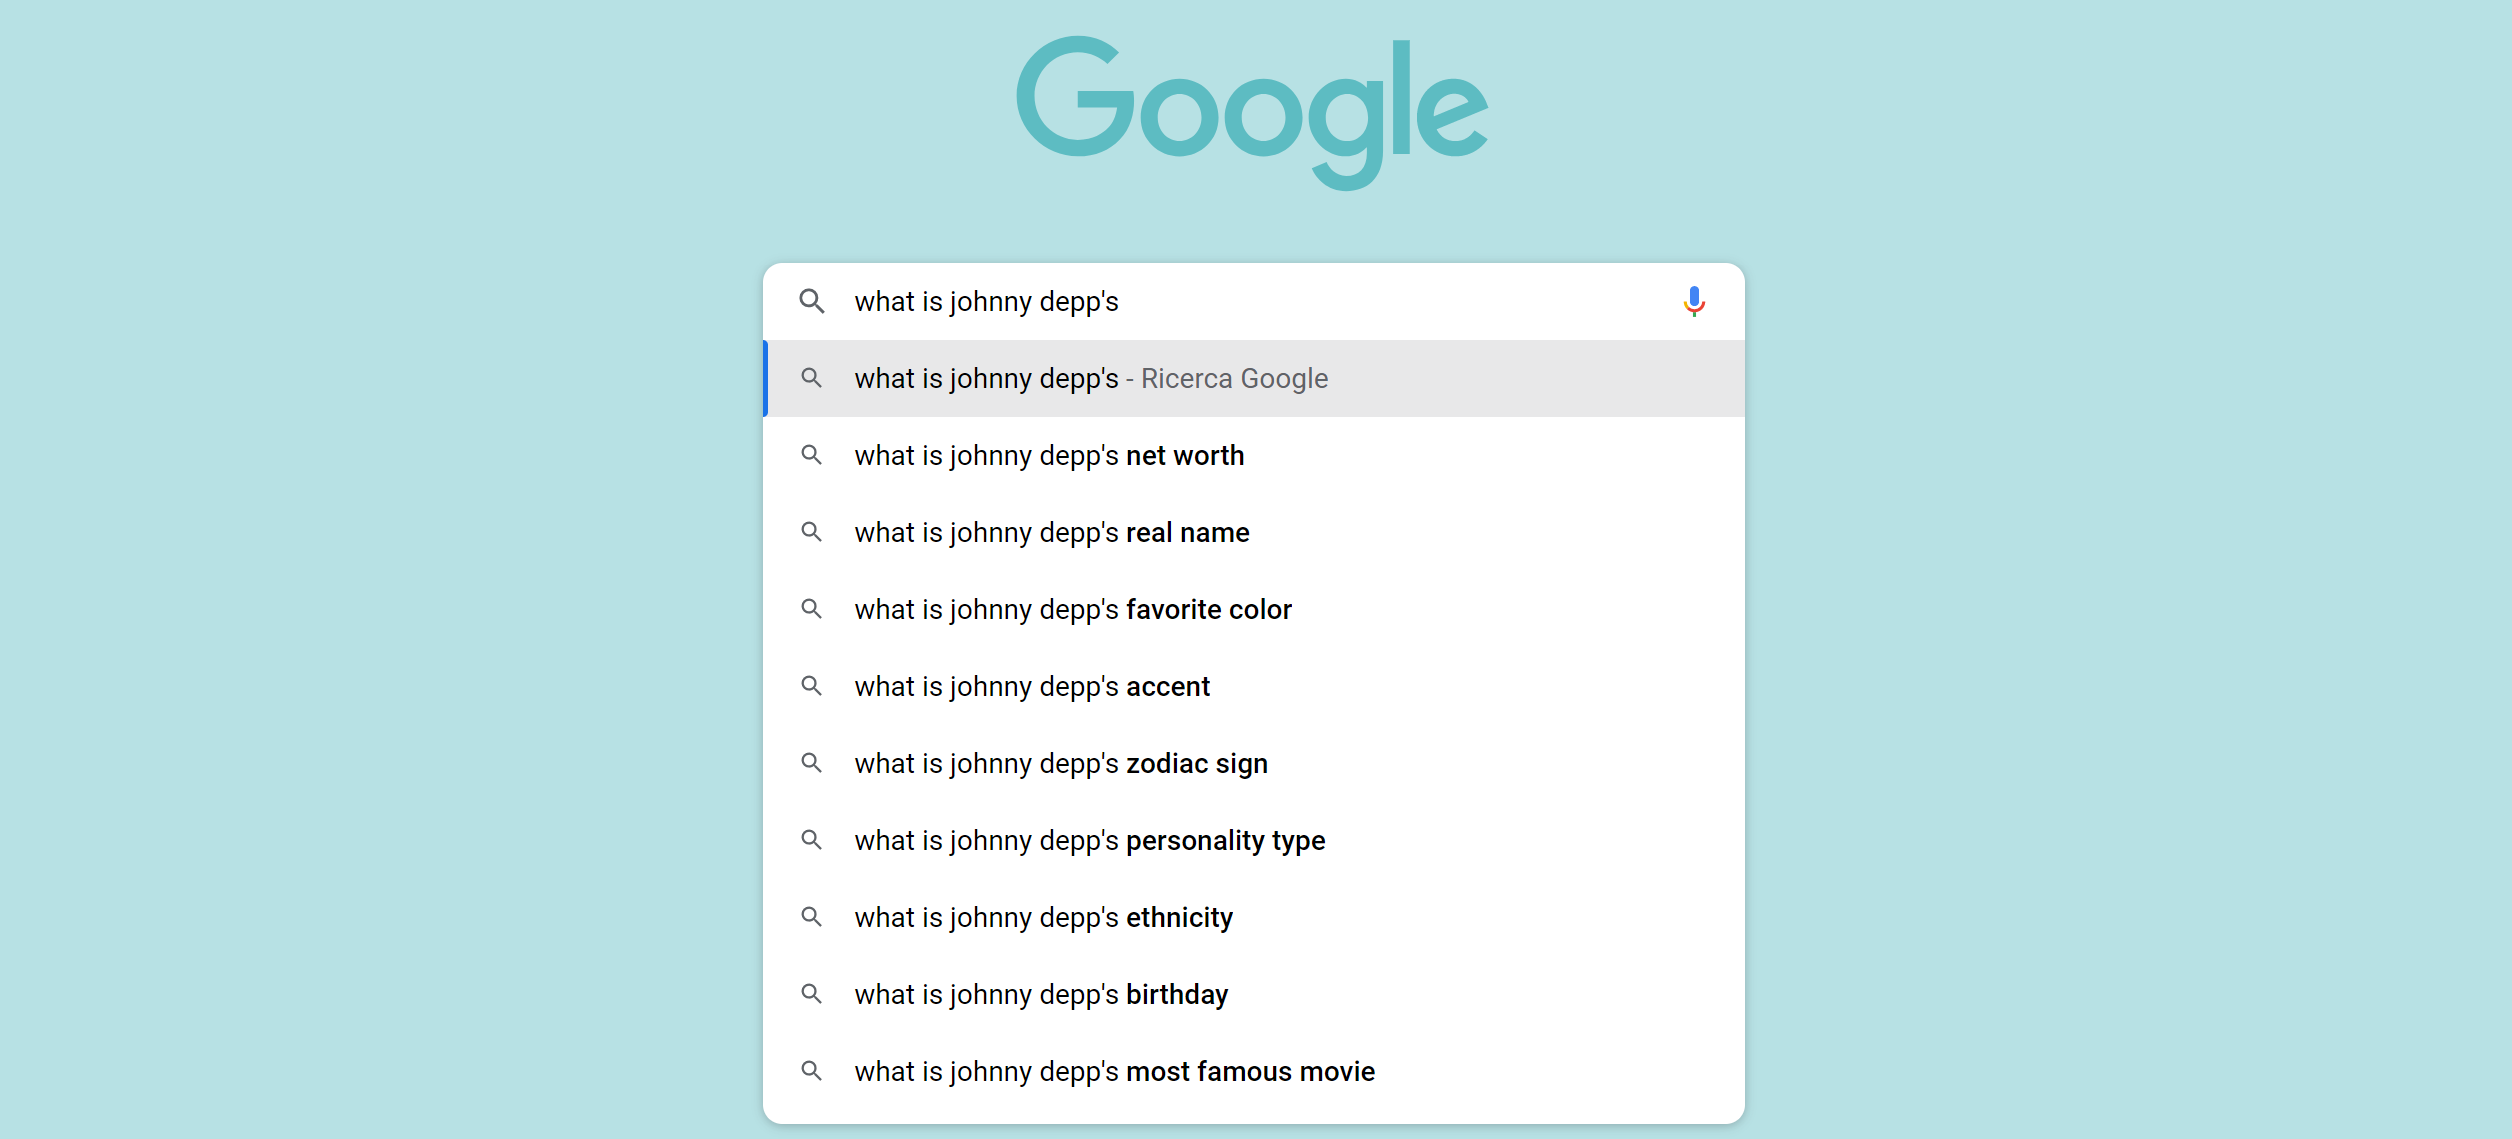

## Left-to-right modeling framework

$$
P\text{( I saw a fluffy cat )}
$$
    
To estimate the probability of a sentence in a language, we can simply use its frequency in a corpus.\
However, with these approach any sentence than never occured in our corpus, will receive zero probability.\
Instead, we use the chain rule to estimate the probability to observe a sequence of tokens in a specific order.\
The chain rule decomposes the probability of a text into conditional probabilities of each token given the previous context.\
By context we mean those words appearing to the left of the current word.

$$ P(\text{ I},\text{ saw},\text{ a},\text{ fluffy}, \text{ cat } ) = P(\text{ I }) · P(\text{ saw }|\text{ I } ) · P(\text{ a }| \text{ I, saw }) · P(\text{ fluffy } | \text{ I, saw, a } ) · P(\text{ cat } | \text{ I, saw, a, fluffy } ) $$

Question: How to compute conditional probabilities ?  

## N-gram Language Model

Estimates of conditional probabilities are based on global statistics from a text corpora, i.e. counts.

$$ P(w_i| w_1, .., w_{i-1} ) = \frac{count (w_1, .., w_{i-1}, w_i)}{count( w_1, .., w_{i-1}, w_i)}  $$

The key components of N-gram language model are Markov Property and smoothing.

#### Markov property (Independence assumption)
The n-gram model assumes that the probability of a word (gram) only depends on a fixed number of previous words. \
Thus, the model approximates the conditional probability of a word, conditioning on n - 1 previous words.\
For example, consider a 3-gram model :


$$ P(\text{ I},\text{ saw},\text{ a},\text{ fluffy}, \text{ cat } ) = P(\text{ I }) · P(\text{ saw }|\text{ I } ) · P(\text{ a }| \text{ I, saw }) · P(\text{ fluffy } | \text{ saw, a } ) · P(\text{ cat } | \text{ a, fluffy } ) $$


#### Smoothing
In case of zero count appearing at denominator or numerator, smoothing is used to redistribute probability mass among seen and unseen events. \
Avoid zeros in the numerator, by adding 1, or some small quantity to all counts, pretending to have seen all n-grams at least once.\
This technique is called laplace smoothing.


### Neural Language Model 

Neural LMs train a network to predict conditional probabilities of a token given its context.\
* encode the context (previous words) into a vector representation
* from this representation predict the probability distribution for the next token.

A neural LM can be seen as a classifier: \
it classifies the context of a text into a number of classes equal to the number of tokens in the vocabulary.

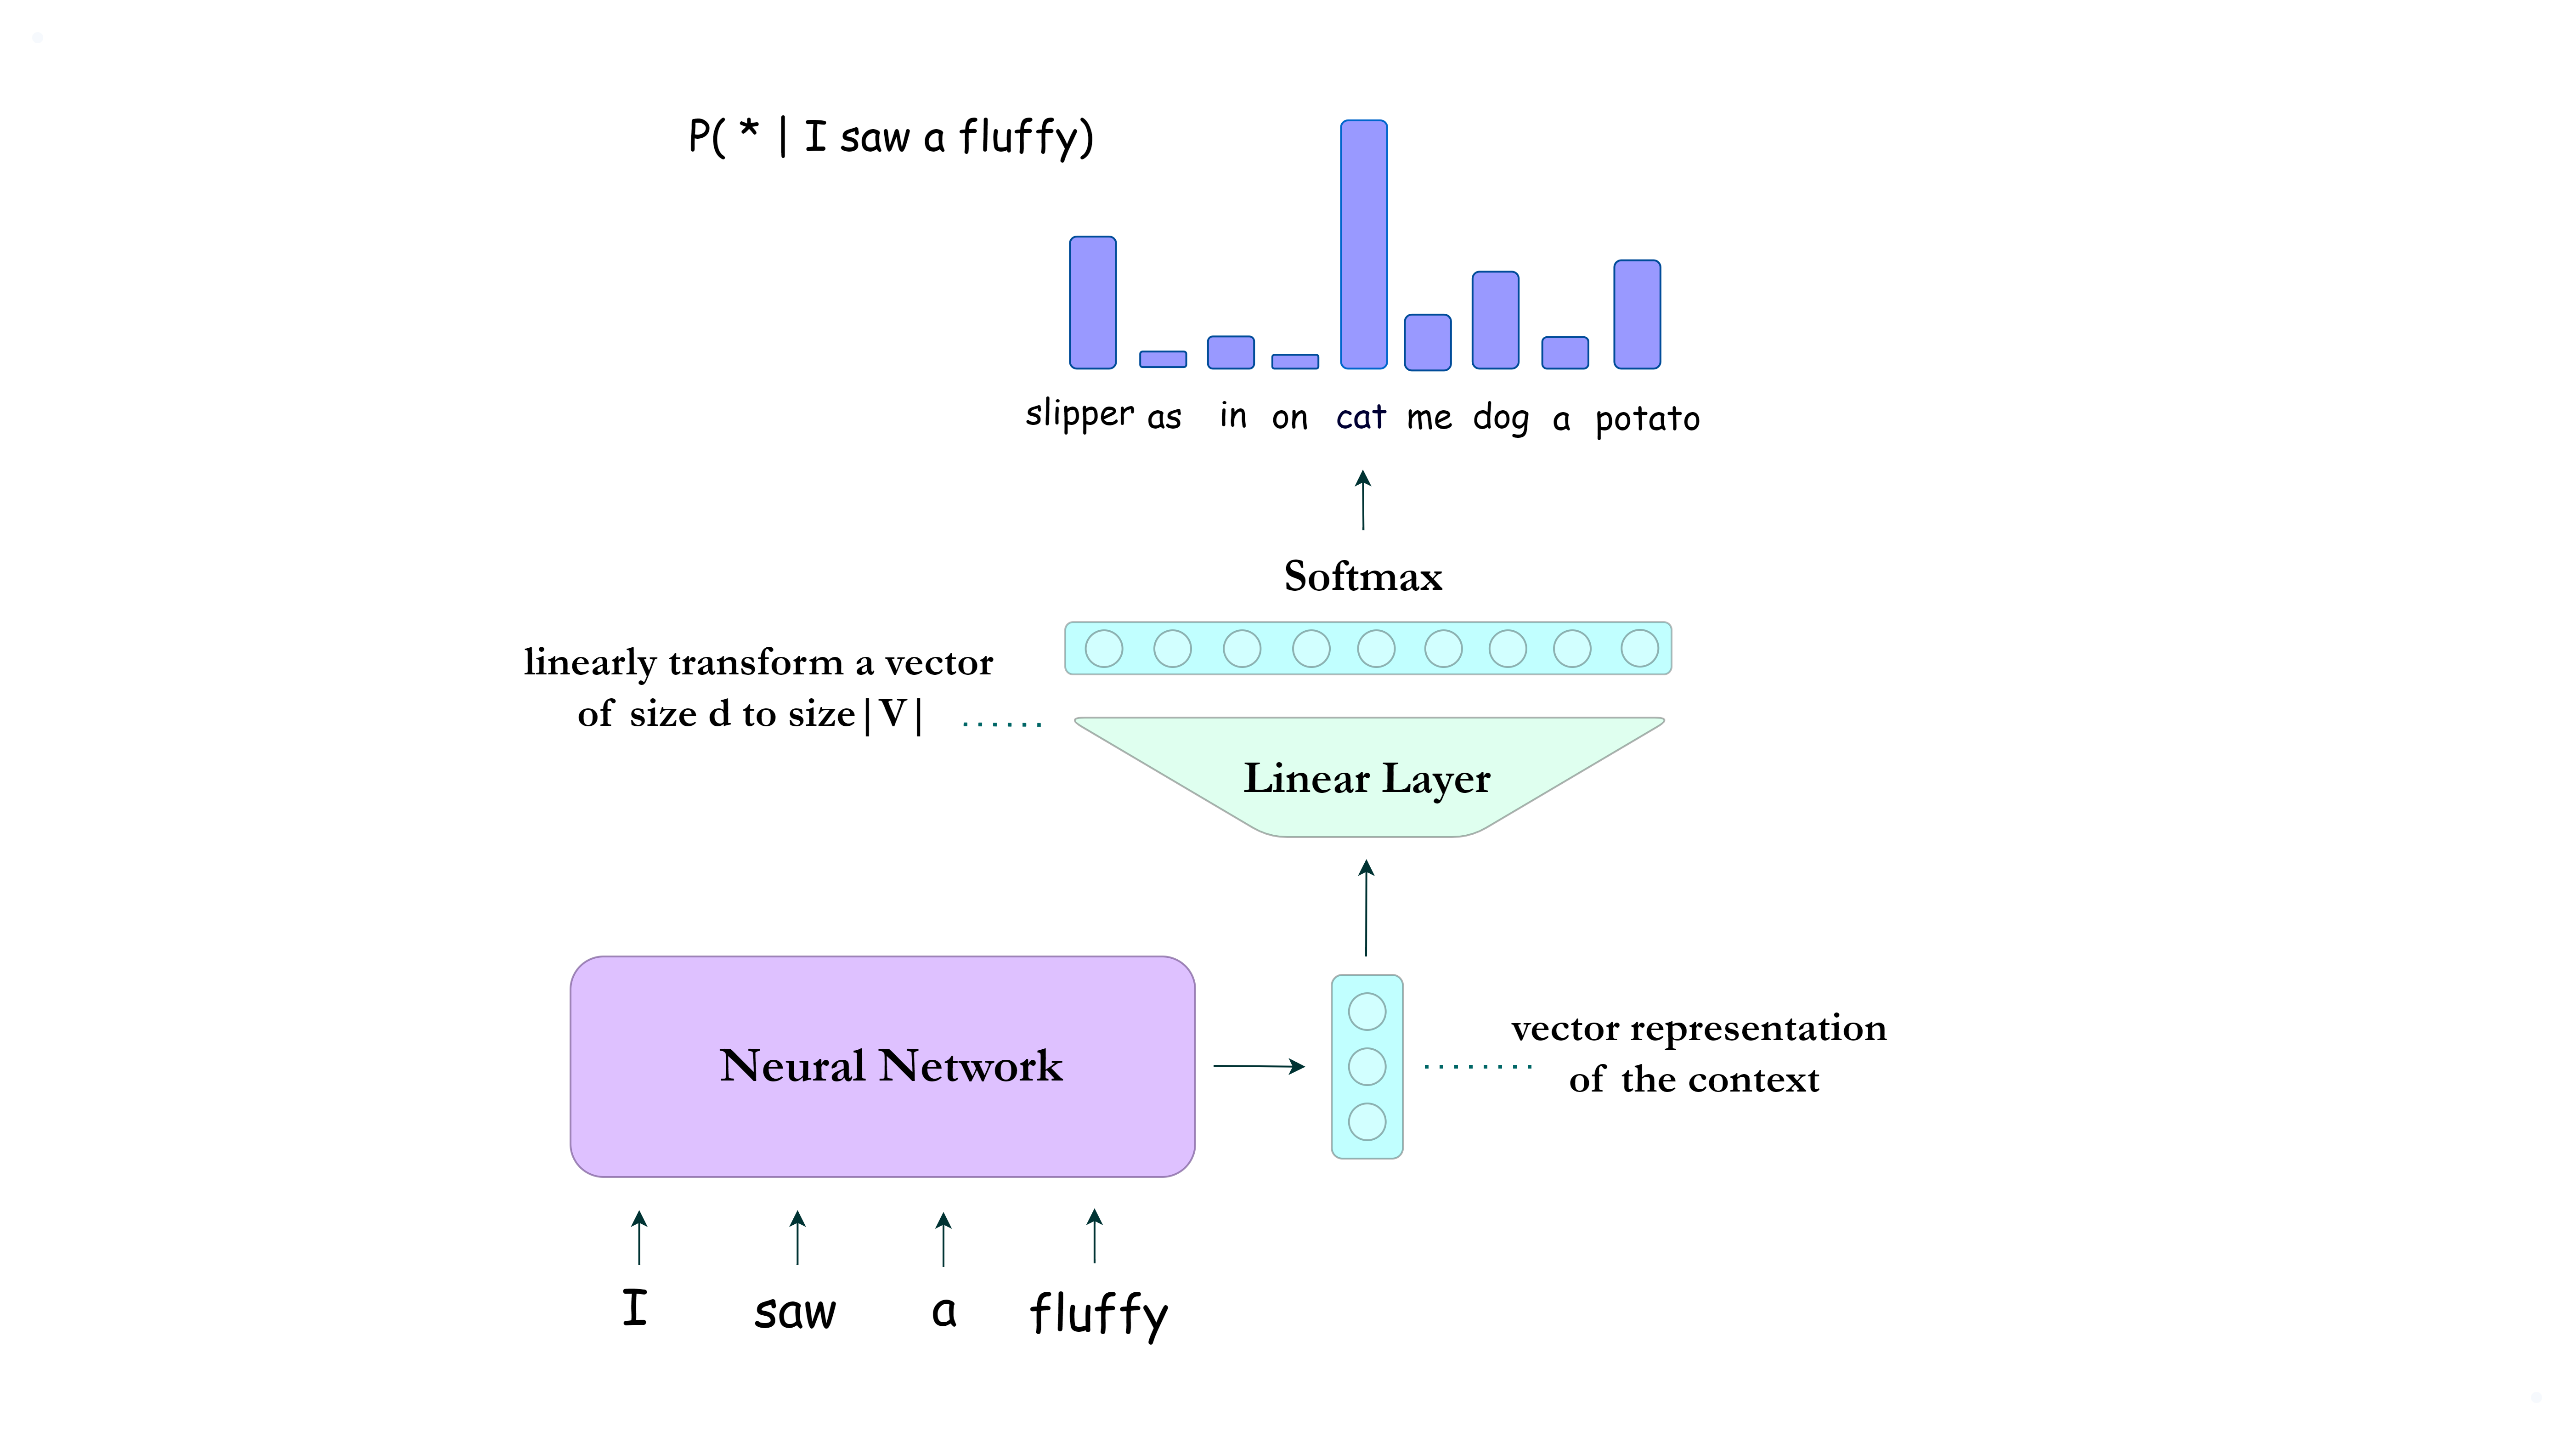

### How can we generate text with a LM ?
* step 0: start with a current context (called prefix)
* step 1: generate a probability distribution for the next token over all tokens in the vocabulary
* step 2: sample a token from the distribution
* step 4: add the token to prefix 
* step 5: repeat the previous steps

##  Model Shakespeare characters' language

Our corpus consists of 40,000 lines of Shakespeare from a variety of Shakespeare's plays.

In [ ]:
import numpy as np
import re, nltk
from tqdm.notebook import tqdm
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter, OrderedDict
from torchtext.vocab import vocab

nltk.download("punkt")

In [39]:
with open(r"\shakespeare_tiny.txt") as file:
    plays = file.read()

In [131]:
print(plays[522001:522700])


Yet 'banished'? Hang up philosophy!
Unless philosophy can make a Juliet,
Displant a town, reverse a prince's doom,
It helps not, it prevails not: talk no more.

FRIAR LAURENCE:
O, then I see that madmen have no ears.

ROMEO:
How should they, when that wise men have no eyes?

FRIAR LAURENCE:
Let me dispute with thee of thy estate.

ROMEO:
Thou canst not speak of that thou dost not feel:
Wert thou as young as I, Juliet thy love,
An hour but married, Tybalt murdered,
Doting like me and like me banished,
Then mightst thou speak, then mightst thou tear thy hair,
And fall upon the ground, as I do now,
Taking the measure of an unmade grave.

FRIAR LAURENCE:
Arise; one knocks; good Romeo, hide thy


Retrieve names for all characters appearing in the corpus.

In [79]:
characters = defaultdict(int)

for reply in plays.split("\n\n"):
    match = re.search(r"[A-Z]\w+( \w+)*:\n", reply)
    if match is not None:
        characters[match.group(0).strip(":\n")] += 1
        
characters = [name for name, freq in sorted(characters.items(), key=lambda x: x[1], reverse=True)]
print("Number of charaters in the dataset:", len(characters))
print("Names of the eight most relevant characters in the Shakespears plays:\n", characters[:8])

Number of charaters in the dataset: 271
Names of the eight most relevant characters in the Shakespears plays:
 ['GLOUCESTER', 'DUKE VINCENTIO', 'MENENIUS', 'ROMEO', 'CORIOLANUS', 'KING RICHARD III', 'ISABELLA', 'JULIET']


We lowercase the text and place EOS token at the end of each charater reply.

In [8]:
plays = re.sub(r"\n\n", " EOS ", plays.lower())

 Split the corpus of plays into tokens.

In [10]:
tokenized_text = word_tokenize(plays)

Build the mapping from tokens to integers.

In [72]:
PAD = 0
UNK = 1

counter = Counter(tokenized_text)
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)
token2idx = vocab(ordered_dict, specials=['PAD', 'UNK'])
idx2token = {idx:token for token, idx in token2idx.get_stoi().items()}
token2idx.set_default_index(UNK)

Encode the text using the defined mapping.

In [12]:
encoded_text = [token2idx[token] for token in tokenized_text]

In [13]:
class NGramModel(object):
    
    def __init__(self, n = 2):
        self.ngrams = defaultdict(Counter)
        self.n = n
        
    def compute_ngrams(self, dataset):
        
        """ Collect counts for ngrams from the necoded corpus. """
        
        for row in tqdm(dataset):
            ngram = [token2idx["PAD"]] * self.n # [0, 0, 0] if n = 3
            # move the ngram window one token at a time
        for token in dataset:
            ngram[:-1] = ngram[1:]
            ngram[-1] = token
            # update the ngram counter
            self.ngrams[tuple(ngram[:-1])].update([ngram[-1]])

    def compute_log_prob(self, prefix):
        
        """ Compute log probabilities from ngram frequencies."""
        
        k = self.n-1
        if len(prefix) < k:
        # if prefix is shorter than k-len window, pad with zeros
            prefix = [token2idx["PAD"]] * (k - len(prefix)) + prefix
        else:
        # take the last k tokens of the prefix 
            prefix = prefix[-k:]

        possible_ends = self.ngrams[tuple(prefix)]
        if len(possible_ends)>0:
            log_sum = np.log(sum(possible_ends[e] for e in self.ngrams[tuple(prefix)]))
            return {e: np.log(possible_ends[e])-log_sum for e in possible_ends} 
        else:
            return {}

    def sample_next(self, prefix):
        """ 
        Sample the next token for a given prefix according to the frequency learned from data.
        
        Args:
            prefix: List[int]
            
        Returns:
            next token: int
        
        """
        next_tok_prob = self.compute_log_prob(prefix)
        if len(next_tok_prob)>0:
            next_token, next_prob = next_tok_prob.keys(), next_tok_prob.values()
            end = np.random.choice(list(next_token), p = np.exp(list(next_prob)))
            return end
        return token2idx["EOS"]

In [16]:
ngram_model = NGramModel(n = 3)
ngram_model.compute_ngrams(encoded_text)

  0%|          | 0/234815 [00:00<?, ?it/s]

In [54]:
def make_me_speak(name, max_len_text=1000):
    
    """ 
    Generate text for a given character.
    
    Args:
        name: str
        max_len_text: int
        
    Returns:
        generated_text: str
    """
    
    assert isinstance(name, str)
    prefix = name.lower().split()
    if len(prefix)==1:
        prefix = prefix + [":"]
        
    encoded_prefix = [token2idx[token] for token in prefix]
    for i in range(max_len_text):
        next = ngram_model.sample_next(encoded_prefix)
        if next == token2idx["EOS"]:
            break
        encoded_prefix += [next]
    
    decoded_text = [idx2token[idx] for idx in encoded_prefix]
    return " ".join(decoded_text)

In [140]:
make_me_speak("Romeo")

"romeo : a name o ' thursday let it keep one shape , and not our tongues ."